In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [2]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [3]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]

t_span = (0, 200)  #the range of time units
dt = 0.001  #the timestep (dt=0.001 is a pretty decent value to stay at)

epsilon = 0.01  #noise strength (0.01 has been well used)

#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon):
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))
    R = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]
    R[0] = 0

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.vstack((s, U))
    return t, y

In [4]:
start_time = time.time()

#Evaluate the function
t_em, y_em = euler_maruyama(initial_state, t_span, dt, epsilon)


R_value_em = 0.25 * k * (k_plus**2 - k_e**2) * y_em[0] * y_em[2]

#Calculate the time average values
mean_R_value_em = np.mean(R_value_em)
mean_y_em_4 = np.mean(y_em[4])


elapsed_time = time.time()-start_time
print(elapsed_time)

6.863123893737793


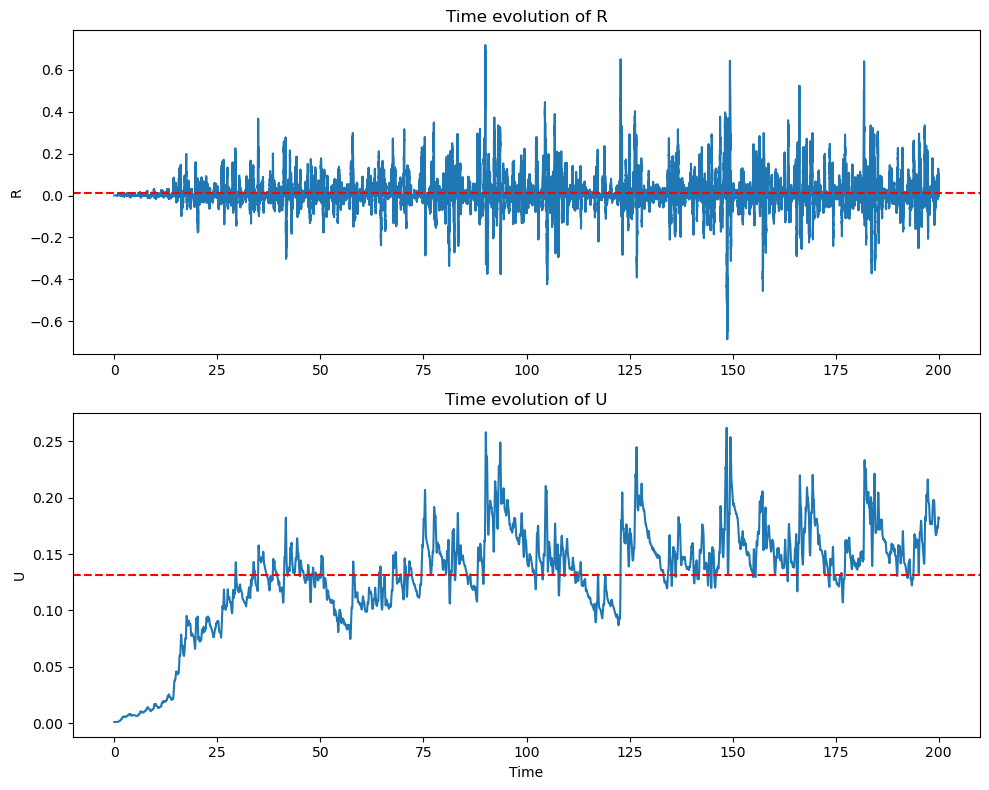

In [5]:
#Plot the time evaluations of R and U

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(t_em, R_value_em,'-')
axs[0].set_title("Time evolution of R")
axs[0].set_ylabel("R")
axs[0].axhline(mean_R_value_em, linestyle='--', color='r')
#axs[0].set_ylim(-1,1)

axs[1].plot(t_em, y_em[4],'-')
axs[1].set_title("Time evolution of U")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("U")
axs[1].axhline(mean_y_em_4, linestyle='--', color='r')


plt.tight_layout()
plt.show()

In [ ]:
np.var

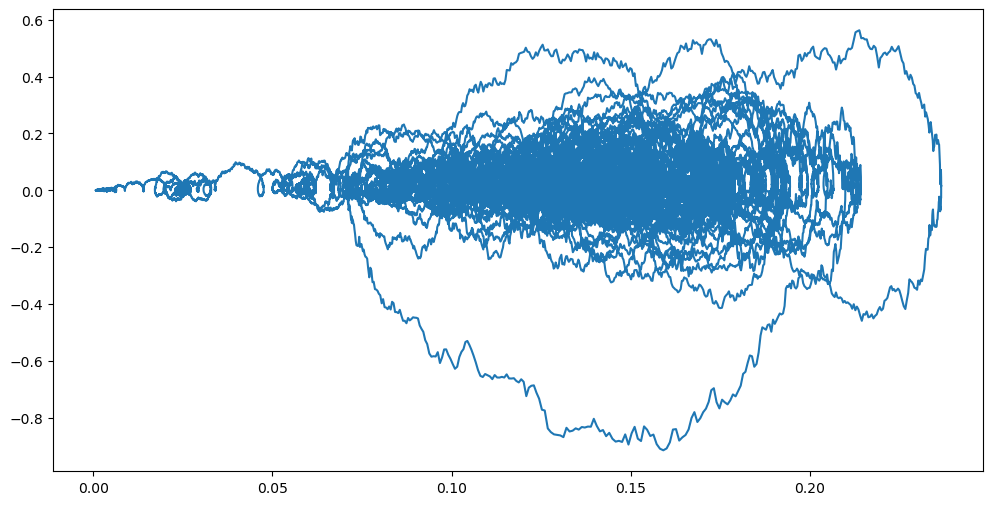

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(y_em[4], R_value_em,'-')

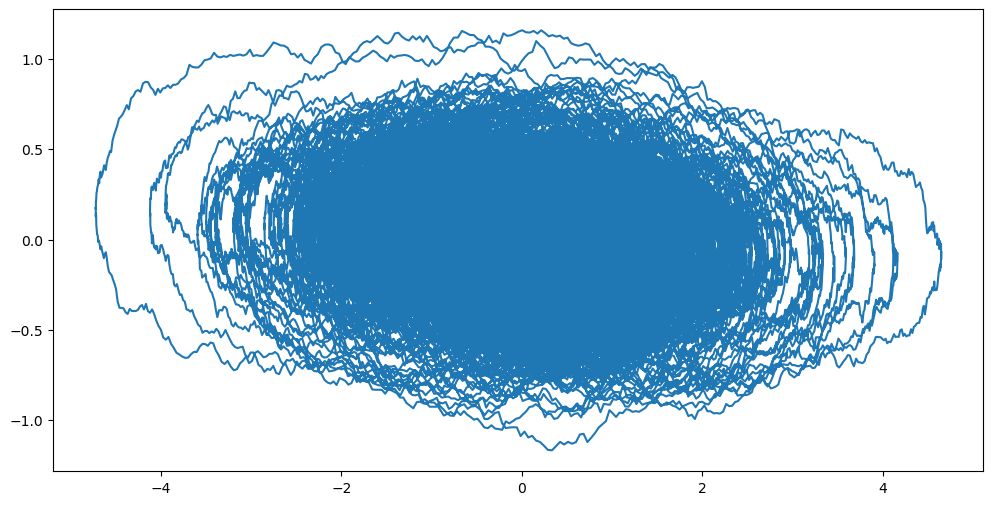

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(y_em[1], y_em[0]*100,'-')

In [7]:
#Compute the Perturbation Streamfunction "Psi", the perturbation buoyancy "b", and the VSHF "U" in the form oflow-order Fourier truncations-

def compute_psi_b_U(y, X, Z, m_U):
    psi_e = y[0]
    psi_plus = y[2]
    b_e = y[1]
    b_plus = y[3]
    U = y[4]

    psi = psi_e * np.sin(k * X) * np.sin(m * Z) + psi_plus * np.cos(k * X) * np.cos((m + m_U) * Z)
    b = b_e * np.cos(k * X) * np.sin(m * Z) + b_plus * np.sin(k * X) * np.cos((m + m_U) * Z)
    U_z_t = U * np.sin(m_U * Z)

    return psi, b, U_z_t

In [8]:
# Parameters
# Create the mesh for all the plots

x = np.linspace(0, 1, 100)
z = np.linspace(0, 1, 100)
X, Z = np.meshgrid(x, z)

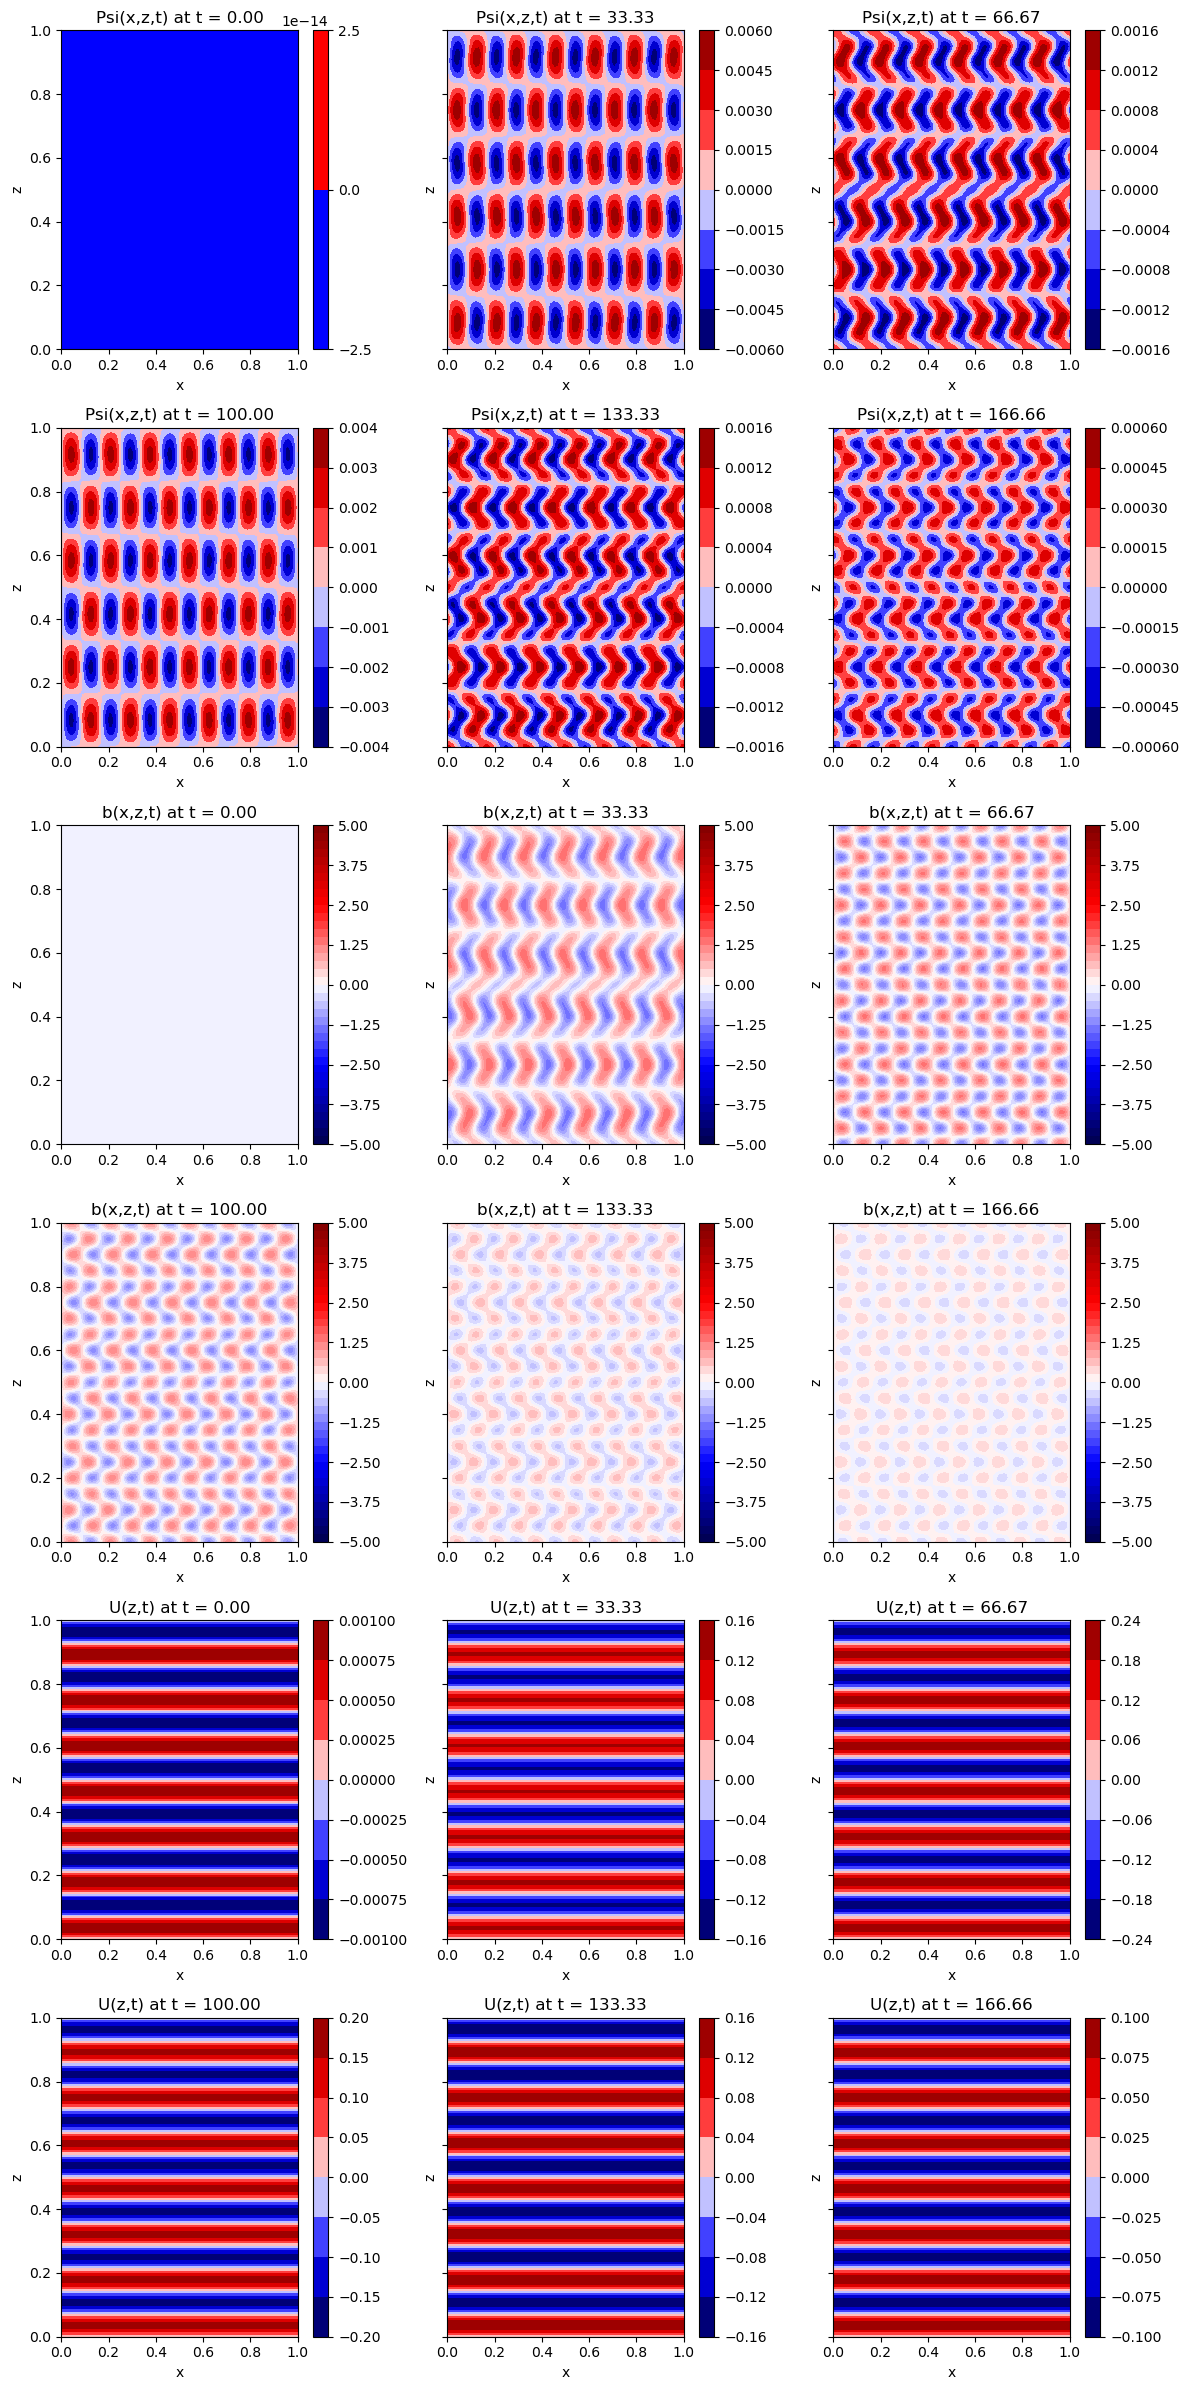

In [10]:
def plot_spatial_visualization(t_indices, y_em, X, Z, m_U):
    n_plots = len(t_indices)
    ncols = 3
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows*3, ncols, figsize=(12, 4 * nrows*3), sharey=True)
    axes = axes.ravel()

    for i, t_index in enumerate(t_indices):
        psi, b, U_z_t = compute_psi_b_U(y_em[:, t_index], X, Z, m_U)
        
        cmap = 'seismic'
        
        c_psi = axes[i].contourf(X, Z, psi, cmap=cmap)
        #psi min: -0.0006914023528692089, psi max: 0.012317839877306567
        axes[i].set_title(f"Psi(x,z,t) at t = {t_em[t_index]:.2f}")
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("z")
        fig.colorbar(c_psi, ax=axes[i])

        c_b = axes[i + n_plots].contourf(X, Z, b, cmap=cmap, levels=np.linspace(-5, 5, 41))
        #b min: -4.896346780997259, b max: 4.896346780997257
        axes[i + n_plots].set_title(f"b(x,z,t) at t = {t_em[t_index]:.2f}")
        axes[i + n_plots].set_xlabel("x")
        axes[i + n_plots].set_ylabel("z")
        fig.colorbar(c_b, ax=axes[i + n_plots])

        c_U = axes[i + 2 * n_plots].contourf(X, Z, U_z_t, cmap=cmap)
        #U_z_t min: -0.263469764131289, U_z_t max: 0.263469764131289
        axes[i + 2 * n_plots].set_title(f"U(z,t) at t = {t_em[t_index]:.2f}")
        axes[i + 2 * n_plots].set_xlabel("x")
        axes[i + 2 * n_plots].set_ylabel("z")
        fig.colorbar(c_U, ax=axes[i + 2 * n_plots])
        

    plt.tight_layout()
    plt.show()

# Choose time indices at regular intervals
n_plots = 6
time_indices = np.arange(0, len(t_em), len(t_em) // n_plots)[:n_plots]

plot_spatial_visualization(time_indices, y_em, X, Z, m_U)

In [13]:
##Code for the animation
#This code produces individual .mp4 animation files for Psi, b, and U

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

num_frames = 100
frame_indices = np.linspace(0, len(t_em) - 1, num_frames).astype(int)

def create_animation(y_em, X, Z, m_U, variable_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = None

    def update(i):
        nonlocal cax
        t_index = frame_indices[i]
        psi, b, U_z_t = compute_psi_b_U(y_em[:, t_index], X, Z, m_U)

        if cax:
            cax.remove()

        if variable_name == 'psi':
            cax = ax.contourf(X, Z, psi, cmap='seismic')
            ax.set_title(f"Psi(x,z,t) at t = {t_em[t_index]:.2f}")
        elif variable_name == 'b':
            cax = ax.contourf(X, Z, b, cmap='seismic', levels=np.linspace(-5, 5, 41))
            ax.set_title(f"b(x,z,t) at t = {t_em[t_index]:.2f}")
        elif variable_name == 'U':
            cax = ax.contourf(X, Z, U_z_t, cmap='seismic', levels=np.linspace(-0.4, 0.4, 41))
            ax.set_title(f"U(z,t) at t = {t_em[t_index]:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        return cax,

    ani = FuncAnimation(fig, update, frames=num_frames, interval=1000, blit=False)
    ani.save(f"{variable_name}_animation.mp4", writer='ffmpeg', fps=5, dpi=100)

create_animation(y_em, X, Z, m_U, 'psi')
create_animation(y_em, X, Z, m_U, 'b')
create_animation(y_em, X, Z, m_U, 'U')

In [11]:
# psi_min, psi_max = float('inf'), float('-inf')
# b_min, b_max = float('inf'), float('-inf')
# U_z_t_min, U_z_t_max = float('inf'), float('-inf')

# for i in range(len(t_em)):
#     psi, b, U_z_t = compute_psi_b_U(y_em[:, i], X, Z, m_U)
    
#     psi_min = psi.min()
#     psi_max = max(psi_max, psi.max())
    
#     b_min = min(b_min, b.min())
#     b_max = max(b_max, b.max())
    
#     U_z_t_min = min(U_z_t_min, U_z_t.min())
#     U_z_t_max = max(U_z_t_max, U_z_t.max())

# print(f"psi min: {psi_min}, psi max: {psi_max}")
# print(f"b min: {b_min}, b max: {b_max}")
# print(f"U_z_t min: {U_z_t_min}, U_z_t max: {U_z_t_max}")

In [38]:
dt = 0.01

T = 200

t = np.linspace(0,T,int(T/dt)+1)

C = np.zeros((4,4,len(t)))

U = np.zeros((len(t),1))

Q = np.zeros((4,4,len(t)))

Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01

r_m = 0.1
N0_squared = 100

C[:,:,0] = 0

U[0] = .001

def rhs(t, U_and_C, r_m, W, L, epsilon, Q):
    U = U_and_C[0]
    C = U_and_C[1:].reshape(4, 4)
    A = W + U*L
    R = C[0, 2]*(0.25 * k * ((k_plus**2) - (k_e**2)))
    dCdt = A @ C + C @ A.T + epsilon*Q
    return np.array([-r_m*U + R, *dCdt.flatten()])

def rk4_method(rhs, y0, t_span, dt, *args):
    
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    y = np.zeros((len(y0), len(t)))
    y[:, 0] = y0

    for i in range(1, len(t)):
        k1 = rhs(t[i-1], y[:, i-1], *args)
        k2 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k1, *args)
        k3 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k2, *args)
        k4 = rhs(t[i-1] + dt, y[:, i-1] + dt * k3, *args)

        y[:, i] = y[:, i-1] + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

    return t, y

U0 = 0.001
C0 = np.zeros((4, 4))
initial_conditions = np.array([U0, *C0.flatten()])

# Solve the ODE system using rk4_method
t, solution = rk4_method(rhs, initial_conditions, (0, T), dt, r_m, W, L, epsilon, Q[:,:,0])


U = solution[0, :]
C = solution[1:].reshape(-1, 4, 4)

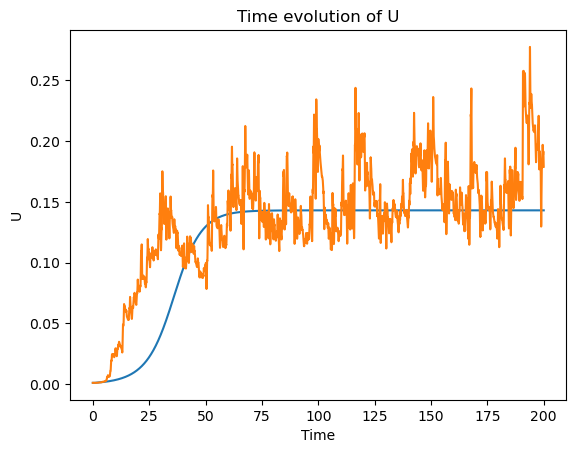

In [40]:
plt.plot(t, U)
plt.plot(t_em, y_em[4])
plt.xlabel('Time')
plt.ylabel('U')
plt.title('Time evolution of U')
plt.savefig("time_evolution_of_U.png")
plt.show()